<a href="https://colab.research.google.com/github/Chibuzo75/CHIBUZO/blob/main/Data_Augmentation_horizontal_vertical_flips_withKerasTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgtf1K_VFVQNg0yX5kq4lohKJkgEAdMPmSrWFlf-LpsZ1HT9KvDj14


Mounted at /content/drive


In [2]:
 !unzip "/content/drive/MyDrive/DigitalTwins/Image_annotation_8images_batch1.zip"
 

Archive:  /content/drive/MyDrive/DigitalTwins/Image_annotation_8images_batch1.zip
   creating: Image_annotation_8images_batch1/
   creating: Image_annotation_8images_batch1/classes/
  inflating: Image_annotation_8images_batch1/classes/classes.json  
  inflating: Image_annotation_8images_batch1/2001_3.png___objects.json  
  inflating: Image_annotation_8images_batch1/1414.png___objects.json  
  inflating: Image_annotation_8images_batch1/1420.png___objects.json  
  inflating: Image_annotation_8images_batch1/2001_2.png___objects.json  
  inflating: Image_annotation_8images_batch1/2201_1.png___objects.json  
  inflating: Image_annotation_8images_batch1/2001_1.png___objects.json  
  inflating: Image_annotation_8images_batch1/1422.png___objects.json  
  inflating: Image_annotation_8images_batch1/1421.png___objects.json  


In [4]:
 !unzip "/content/drive/MyDrive/DigitalTwins/Not Annotated/PIDs-images_200dpi_batch2.zip"

Archive:  /content/drive/MyDrive/DigitalTwins/Not Annotated/PIDs-images_200dpi_batch2.zip
  inflating: 1110.png                
  inflating: 1111.png                
  inflating: 1112.png                
  inflating: 1113.png                
  inflating: 1114.png                
  inflating: 1121.png                
  inflating: 1122.png                
  inflating: 1201.png                
  inflating: 1201_1.png              
  inflating: 1202_1.png              
  inflating: 1203_1.png              
  inflating: 1203_2.png              
  inflating: 1204.png                
  inflating: 1206.png                
  inflating: 1207.png                
  inflating: 1208.png                
  inflating: 1209.png                
  inflating: 1310.png                
  inflating: 1311.png                
  inflating: 1312.png                
  inflating: 1412.png                
  inflating: 2301_1.png              
  inflating: 2301_2.png              
  inflating: 2302.png               

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import cv2
import random
import os
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#I DID NOT RUN THIS CODE BECAUSE I HAVE ALREADY CREATED THE SYMBOLS FOLDER ON MY DRIVE. IT IS HERE ONLY TO SHOW HOW I CREATED IT!
from PIL import Image
def check_folder_exists(path):
        if not os.path.exists(path):
            try:
                os.makedirs(path)
                print ('create ' + path)
            except OSError as e:
                if e.errno != errno.EEXIST:
                    raise

original_img_folder = img1 ="/content/drive/MyDrive/DigitalTwins/Not Annotated/PIDs-images_200dpi" #you images directory
annotation_dir = r"/content/drive/MyDrive/DigitalTwins/Image_annotation_8images_batch1/"   #this link also works /content/Image_annotation_8images_batch1/
sym='/content/drive/MyDrive/DigitalTwins/symbols/'

for filename in os.listdir(original_img_folder):
  if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
    #load image 
    load_img_path = os.path.join(original_img_folder, filename)
    #load annotation
    annotation_x=None
    with open(annotation_dir+filename+'___objects.json') as e:
      annotation_x = json.load(e)
    p_id = pd.DataFrame(annotation_x['instances'])
    
    for index, row in p_id.iterrows():
      #save img1 path----------
      if row['type']=='bbox':
        save_class_path = os.path.join(sym, row['className'])
        check_folder_exists(save_class_path)
        save_img_path = os.path.join(save_class_path, str(index)+'_'+filename)
        
        img1 = Image.open(load_img_path)
        crop_img1 = img1.crop((int(row['points']['x1']) ,int(row['points']['y1']) ,int(row['points']['x2']) ,int(row['points']['y2'])))
        newsize = ((int(row['points']['x2'])-int(row['points']['x1']))*10,(int(row['points']['y2'])-int(row['points']['y1']))*10)#(224, 224) 
        
        im1 = crop_img1.resize(newsize) 
        im1.save(save_img_path, 'PNG')

In [4]:
!ls "/content/drive/MyDrive/DigitalTwins/symbols/"

 Actuator     flange	       Instrument     plug	    Unidentified
 Concentric   flange_blind     line_break     separator     valve
 connector    flow_direction   other_lines    tank_vessel
 engine      'Inside text'     piping_lines   text


**GENERATING THE DATASET**

In [5]:
#Generate a data set
image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DigitalTwins/symbols/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DigitalTwins/symbols/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size)

Found 6225 files belonging to 18 classes.
Using 4980 files for training.
Found 6225 files belonging to 18 classes.
Using 1245 files for validation.


**VISUALIZING THE FIRST 9 TRAINING IMAGES**

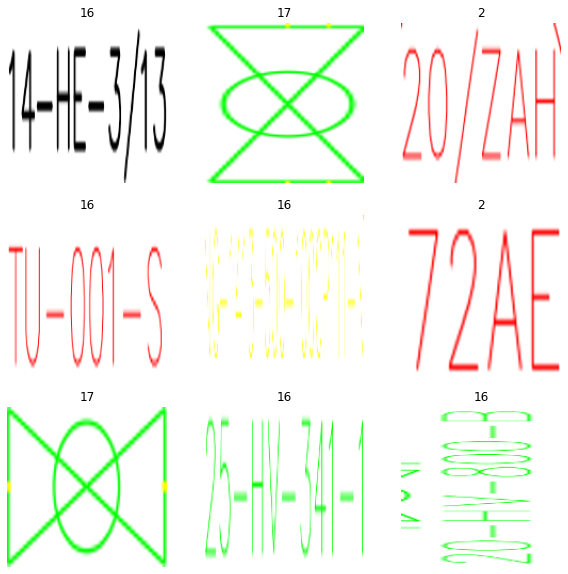

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

**DATA AUGMENTATION PREPROCESSING**

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.5)
    ]
)

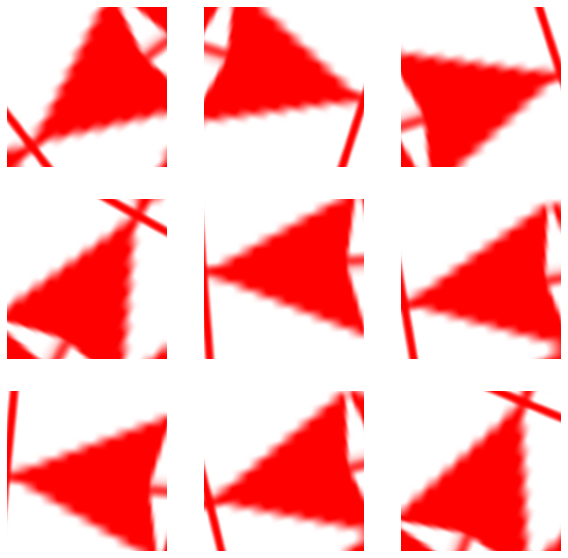

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
#augmented_train_ds = train_ds.map(
  #lambda x, y: (data_augmentation(x, training=True), y))

**CONFIGURING THE DATASET FOR PERFORMANCE**

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

**BUILDING THE MODEL**

In [10]:
# BUILDING THE MODEL
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "softmax"
        units = 1
    else:
         activation = "softmax"
         units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

**TRAINING THE MODEL**

In [11]:
epochs = 3

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer= 'SGD',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/3
156/156 [==============================] - 1120s 7s/step - loss: 0.0000e+00 - accuracy: 0.0104 - val_loss: 0.0000e+00 - val_accuracy: 0.0048
Epoch 2/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


156/156 [==============================] - 943s 6s/step - loss: 0.0000e+00 - accuracy: 0.0104 - val_loss: 0.0000e+00 - val_accuracy: 0.0048
Epoch 3/3
156/156 [==============================] - 956s 6s/step - loss: nan - accuracy: 0.0094 - val_loss: nan - val_accuracy: 0.0096


**OPTIMIZING THE MODEL ARCHITECTURE WITH KERAS TUNER**

In [12]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 96 kB 2.5 MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9568 sha256=7e7a5a2608e187d6be49b0215f4d8e667ec46482156d12cfdda22db958972a3b
  Stored in directory: /root/.cache/pip/wheels/38/5c/e0/13003e68c17f403af40b92a24d20171b95fef13b0fdaba833c
Successfully built kt-legacy


In [13]:

import kerastuner as kt
from tensorflow import keras

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [14]:
from keras_tuner.engine.hypermodel import HyperModel
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.tuners import RandomSearch

**BUILDING THE MODEL FOR KERAS TUNING**

In [28]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(150,150,3)))
    for i in range(hp.get("num_layers")):
        model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.get("learning_rate")),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [29]:
hp = HyperParameters()
hp.Choice("learning_rate", [1e-1, 1e-3])
hp.Int("num_layers", 2, 20)

2

In [30]:
tuner = kt.Hyperband(
    build_model, hyperparameters=hp, objective="val_accuracy", max_epochs=30, hyperband_iterations=2
)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [31]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)]
)

Trial 54 Complete [00h 02m 27s]
val_accuracy: 0.00963855441659689

Best val_accuracy So Far: 0.00963855441659689
Total elapsed time: 02h 50m 44s
INFO:tensorflow:Oracle triggered exit


In [32]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.1
num_layers: 5
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.00963855441659689
Trial summary
Hyperparameters:
learning_rate: 0.1
num_layers: 19
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.00963855441659689
Trial summary
Hyperparameters:
learning_rate: 0.001
num_layers: 12
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.00963855441659689
Trial summary
Hyperparameters:
learning_rate: 0.001
num_layers: 18
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.00963855441659689
Trial summary
Hyperparameters:
learning_rate: 0.001
num_layers: 17
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.00963855441659689
Trial summary
Hyperparameters:
learning_rate: 0.1
num_layers: 1